In [0]:
!pip install facenet-pytorch
# Imports here
#import torch
#import torch.functional as F
#import torch.nn as nn
#import torch.optim as optim
import torch,torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
#from torch import nn, optim
from torch.optim import lr_scheduler
#from torch.autograd import Variable
#from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms
from torchvision import datasets, transforms, models
#from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import json
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import os,cv2
#from facenet_pytorch import MTCNN, InceptionResnetV1
#import pandas as pd
#from pylab import rcParams
#rcParams['figure.figsize'] = 20, 10
import seaborn as sns


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
fer= "/content/gdrive/My Drive/fer2013/FER/fer2013.csv"
#ferr= "./new/fer24"


In [0]:
!pip install mxnet

     |████████████████████████████████| 25.4MB 51.8MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
#! /usr/bin/env python3
# -*-coding: utf-8-*-

__author__ = 'Moonkie'

import numpy as np
import cv2
import mxnet as mx
import pandas as pd
import random
import os

curdir = os.path.abspath(os.path.dirname(fer))

def gen_record(csvfile,channel):
    data = pd.read_csv(csvfile,delimiter=',',dtype='a')
    labels = np.array(data['emotion'],np.float)
    # print(labels,'\n',data['emotion'])
        
    imagebuffer = np.array(data['pixels'])
    images = np.array([np.fromstring(image,np.uint8,sep=' ') for image in imagebuffer])
    del imagebuffer
    num_shape = int(np.sqrt(images.shape[-1]))
    images.shape = (images.shape[0],num_shape,num_shape)
    # img=images[0];cv2.imshow('test',img);cv2.waitKey(0);cv2.destroyAllWindow();exit()
    dirs = set(data['Usage'])
    subdirs = set(labels)
    class_dir = {}
    for dr in dirs:
        dest = os.path.join(curdir,dr)
        class_dir[dr] = dest
        if not os.path.exists(dest):
            os.mkdir(dest)
            
    data = zip(labels,images,data['Usage'])
    
    for d in data:
        destdir = os.path.join(class_dir[d[-1]],str(int(d[0])))
        if not os.path.exists(destdir):
            os.mkdir(destdir)
        img = d[1]
        filepath = unique_name(destdir,d[-1])
        print('[^_^] Write image to %s' % filepath)
        if not filepath:
            continue
        sig = cv2.imwrite(filepath,img)
        if not sig:
            print('Error')
            exit(-1)


def unique_name(pardir,prefix,suffix='jpg'):
    filename = '{0}_{1}.{2}'.format(prefix,random.randint(1,10**8),suffix)
    filepath = os.path.join(pardir,filename)
    if not os.path.exists(filepath):
        return filepath
    unique_name(pardir,prefix,suffix)
    


if __name__ == '__main__':
    filename = 'fer2013.csv'
    filename = os.path.join(curdir,filename)
    gen_record(filename,1)
    
    # ##################### test
    # tmp = unique_name('./Training','Training')
    # print(tmp)

[^_^] Write image to /content/gdrive/My Drive/fer2013/FER/Training/0/Training_84618873.jpg
[^_^] Write image to /content/gdrive/My Drive/fer2013/FER/Training/0/Training_75192022.jpg
[^_^] Write image to /content/gdrive/My Drive/fer2013/FER/Training/2/Training_42449628.jpg
[^_^] Write image to /content/gdrive/My Drive/fer2013/FER/Training/4/Training_6098372.jpg
[^_^] Write image to /content/gdrive/My Drive/fer2013/FER/Training/6/Training_70324793.jpg
[^_^] Write image to /content/gdrive/My Drive/fer2013/FER/Training/2/Training_80443988.jpg
[^_^] Write image to /content/gdrive/My Drive/fer2013/FER/Training/4/Training_98305221.jpg
[^_^] Write image to /content/gdrive/My Drive/fer2013/FER/Training/3/Training_23230433.jpg
[^_^] Write image to /content/gdrive/My Drive/fer2013/FER/Training/3/Training_43978853.jpg
[^_^] Write image to /content/gdrive/My Drive/fer2013/FER/Training/2/Training_56776570.jpg
[^_^] Write image to /content/gdrive/My Drive/fer2013/FER/Training/0/Training_68435047.jpg


In [0]:
data_dir = "/content/gdrive/My Drive/fer2013/FER"
#data_dir = 'flower_data'
train_dir = data_dir + '/Training'
valid_dir = data_dir + '/PublicTest'
test_dir = data_dir + '/PrivateTest'
cat_to_name = data_dir + "/cat_to_name.json"
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train':transforms.Compose([
            transforms.RandomRotation(20),
            transforms.Resize(size=225),
            transforms.CenterCrop((224, 224)),
            transforms.RandomHorizontalFlip(), # randomly flip and rotate
            transforms.ToTensor(),
            # from https://github.com/kuangliu/pytorch-cifar/blob/master/utils.py > get_mean_and_std(dogs_train_dataset)
            transforms.Normalize(torch.tensor([0.485, 0.456, 0.406]), torch.tensor([ 0.229, 0.224, 0.225]))
             ]),
    'valid':transforms.Compose([
            transforms.RandomRotation(20),
            transforms.Resize(size=225),
            transforms.CenterCrop((224, 224)),
            transforms.RandomHorizontalFlip(), # randomly flip and rotate
            transforms.ToTensor(),
            # from https://github.com/kuangliu/pytorch-cifar/blob/master/utils.py > get_mean_and_std(dogs_train_dataset)
            transforms.Normalize(torch.tensor([0.485, 0.456, 0.406]), torch.tensor([ 0.229, 0.224, 0.225]))
             ]),
    'test':transforms.Compose([
                        transforms.Resize(size=224),
            transforms.CenterCrop((224, 224)),
            transforms.RandomHorizontalFlip(), # randomly flip and rotate
            transforms.ToTensor(),
            # from https://github.com/kuangliu/pytorch-cifar/blob/master/utils.py > get_mean_and_std(dogs_train_dataset)
            transforms.Normalize(torch.tensor([0.485, 0.456, 0.406]), torch.tensor([ 0.229, 0.224, 0.225]))
             ])
    }



# TODO: Load the datasets with ImageFolder

dirs = {'train': train_dir, 
        'valid': valid_dir,
        'test': test_dir}

datasets = {x: torchvision.datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid', 'test']}

# TODO: Using the image datasets and the trainforms, define the dataloaders

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, num_workers=num_workers,shuffle=True) for x in ['train', 'valid','test']}

dataset_sizes = {x: len(datasets[x]) 
                              for x in ['train', 'valid','test']}
print(dataset_sizes)


{'train': 28707, 'valid': 3589, 'test': 3589}


In [0]:
import json

with open(cat_to_name, 'r') as f:
    cat_to_name = json.load(f)
print(cat_to_name) 

{'0': 'ANGRY', '1': 'DISGUST', '2': 'FEAR', '3': 'HAPPY', '6': 'NEUTRAL', '4': 'SAD', '5': 'SURPRISE'}


In [0]:
class_names = datasets['train'].classes
print(class_names)

['0', '1', '2', '3', '4', '5', '6']


In [0]:
#from facenet_pytorch import MTCNN, InceptionResnetV1

#mtcnn = MTCNN()
#model = InceptionResnetV1(classify=True, num_classes=7).eval()
model=models.densenet121(pretrained=True)
model.classifier=nn.Linear(1024,7)
model.eval()
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 40958522.01it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
def train_model(model, criteria, optimizer, scheduler = None, epochs=10, device='cuda'):

    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    
    # initialize tracker for accuracy 
    best_acc = 0 
    TS_loss = pd.DataFrame(np.nan, index = range(1,epochs+1), columns = ['train loss','valid loss'])
    TS_acc = pd.DataFrame(np.nan,index = range(1,epochs+1), columns = ['train acc','valid acc'])
    
    for epoch in range(1,epochs+1):
        print('Epoch {}/{}'.format(epoch, epochs))
        print('-' * 10)
        
        # monitor loss/accuracy
        train_loss_running = 0.0
        valid_loss_running = 0.0
        train_acc_running = 0.0
        valid_acc_running = 0.0

        ###################
        # train the model #
        ###################
        if scheduler:
            scheduler.step()
        model.train() # prep model for training
        
        for data, target in dataloaders['train']:
    
            # Move input and data tensors to the default device
            data, target = data.to(device), target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criteria(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss 
            train_loss_running += loss.item()*data.size(0)
            # accuracy
            _, preds = torch.max(output, 1)
            train_acc_running  += torch.sum(preds == target.data)
            
            del loss

        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for data, target in dataloaders['valid']:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criteria(output, target)
                valid_loss_running += loss.item()*data.size(0)
                
                _, preds = torch.max(output, 1)
                valid_acc_running  += torch.sum(preds == target.data)
                
                del loss
                # Calculate accuracy
                #ps = torch.exp(logps)
                #top_p, top_class = ps.topk(1, dim=1)
                #equals = top_class == labels.view(*top_class.shape)
                #accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        # statistics
        train_loss = train_loss_running/ dataset_sizes['train']
        valid_loss = valid_loss_running/ dataset_sizes['valid']
        train_acc = train_acc_running.double()/ dataset_sizes['train']
        valid_acc = valid_acc_running.double()/ dataset_sizes['valid']
        
        TS_loss.loc[epoch] = [train_loss, valid_loss]
        TS_acc.loc[epoch] = [(train_acc.cpu().numpy()), (valid_acc.cpu().numpy())]                                         

        # print training/validation statistics 
        print('Train - Loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc))
        print('Valid - Loss: {:.4f} Acc: {:.4f}'.format(valid_loss, valid_acc))                                                 
                                                             
        # save model if validation acc has increased
        if valid_acc > best_acc:
            print('Validation Acc increased ({:.4f} --> {:.4f}).  Saving model.'.format(best_acc,valid_acc))
            best_model = copy.deepcopy(model.state_dict())                                                                    
            best_acc = valid_acc
        
        print()
    
    #End
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Valid Acc: {:4f}'.format(best_acc))
                                                   
    TS_loss.plot(title = 'loss')
    TS_acc.plot(title = 'acc')
                                                   
    # load best model weights
    model.load_state_dict(best_model)
    torch.save(model.state_dict(), 'model.pt')
    
    return model

Epoch 1/20
----------
Train - Loss: 1.4005 Acc: 0.4604
Valid - Loss: 1.3631 Acc: 0.4915
Validation Acc increased (0.0000 --> 0.4915).  Saving model.

Epoch 2/20
----------
Train - Loss: 1.2032 Acc: 0.5437
Valid - Loss: 1.2011 Acc: 0.5539
Validation Acc increased (0.4915 --> 0.5539).  Saving model.

Epoch 3/20
----------
Train - Loss: 1.1316 Acc: 0.5732
Valid - Loss: 1.1842 Acc: 0.5567
Validation Acc increased (0.5539 --> 0.5567).  Saving model.

Epoch 4/20
----------
Train - Loss: 1.0826 Acc: 0.5904
Valid - Loss: 1.0958 Acc: 0.5876
Validation Acc increased (0.5567 --> 0.5876).  Saving model.

Epoch 5/20
----------
Train - Loss: 1.0436 Acc: 0.6063
Valid - Loss: 1.1006 Acc: 0.5935
Validation Acc increased (0.5876 --> 0.5935).  Saving model.

Epoch 6/20
----------
Train - Loss: 1.0180 Acc: 0.6169
Valid - Loss: 1.0489 Acc: 0.6038
Validation Acc increased (0.5935 --> 0.6038).  Saving model.

Epoch 7/20
----------
Train - Loss: 0.9852 Acc: 0.6282
Valid - Loss: 1.0505 Acc: 0.6080
Validation A

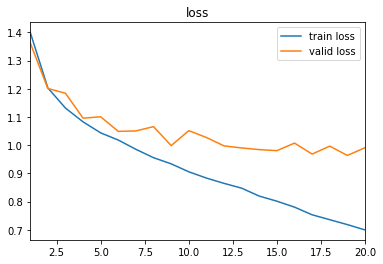

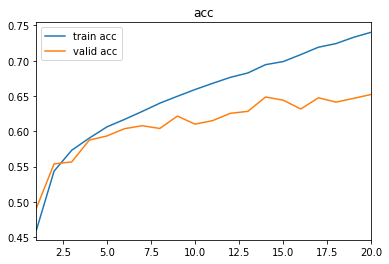

In [0]:
epochs = 20
lr=0.001
# freezing the feature part of the pre-trained model 
for param in model.parameters():
    param.requires_grad = True
    


criteria = nn.CrossEntropyLoss()    
    
optimizer = optim.Adam(model.parameters(), lr=lr)


scheduler = None#lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

model_ft = train_model(model, criteria, optimizer, scheduler, epochs, device)

In [0]:
modely = models.densenet121(pretrained=False)
print(model_ft)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
model = modely.load_state_dict(torch.load('/content/model.pt'))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])


In [0]:
def save_model_checkpoint(model, optimizer, criteria, epochs):
  model.to('cpu')
  model.class_to_idx = datasets['train'].class_to_idx
  checkpoint = {'input_size': 48*48*1,
                'output_size': 7,
                'model': model,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'criterion': criteria,
                'epochs': epochs,
                'class_to_idx': model.class_to_idx}

  path = "/content/gdrive/My Drive/facial_emotions.pth"
  torch.save(checkpoint,path)


# load model function 
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location='cpu')
    model = checkpoint["model"]
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [0]:
epochs = 20
lr=0.001
criteria = nn.CrossEntropyLoss()    
    
optimizer = optim.Adam(model_ft.parameters(), lr=lr)

save_model_checkpoint(model_ft,optimizer,criteria,epochs)

In [0]:
# for param in model_ft.parameters():
#     param.requires_grad = True

# criteria = nn.CrossEntropyLoss()    
    
# optimizer = optim.Adam(model_ft.parameters(), lr=lr)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_ft.to(device);

# epochs = 70

# modelxy = train_model(model_ft, criteria, optimizer,None, epochs, device)

In [0]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

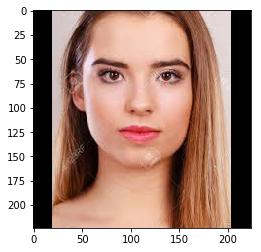

In [0]:
image_path = '/content/gdrive/My Drive/wwwwwww/girl.jpg'
img = process_image(image_path)
imshow(img)

In [0]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.cuda.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().cpu().numpy().tolist()[0] 
    top_labs = top_labs.detach().cpu().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [0]:
model_ft.cuda()

predict('/content/gdrive/My Drive/wwwwwww/41804119_144070169879001_2646434650225901568_n.jpg',model_ft)

([2.926992893218994,
  2.923614978790283,
  2.544461250305176,
  0.15033401548862457,
  0.10328785330057144],
 ['6', '4', '0', '2', '3'],
 ['NEUTRAL', 'SAD', 'ANGRY', 'FEAR', 'HAPPY'])

In [0]:
# TODO: Display an image along with the top 5 classes
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    
    title_ = cat_to_name
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

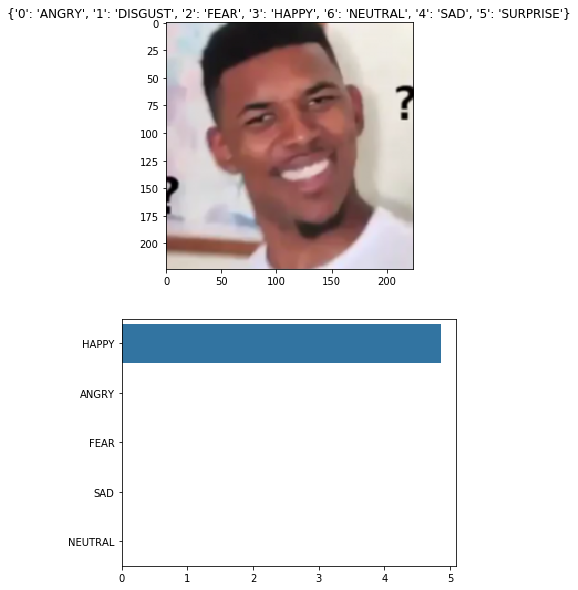

In [0]:
image_path = '/content/gdrive/My Drive/wwwwwww/1AE.png'
plot_solution(image_path, model_ft)

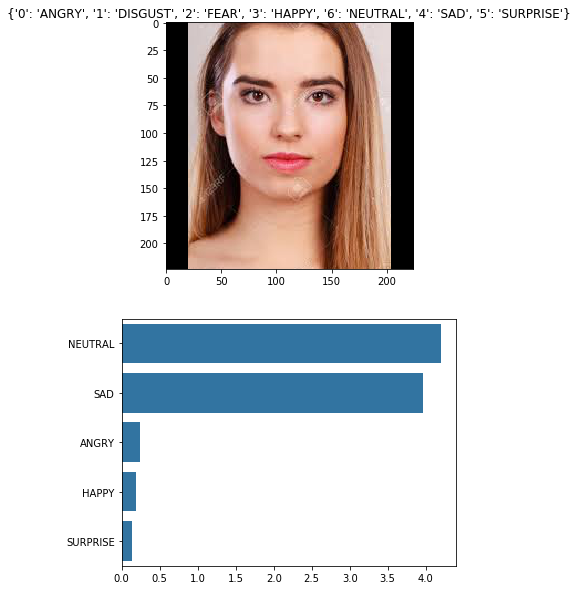

In [0]:
image_path = '/content/gdrive/My Drive/wwwwwww/girl.jpg'
plot_solution(image_path, model_ft)

In [0]:
#! /usr/bin/env python3
# -*-coding: utf-8-*-

__author__ = 'Moonkie'

import numpy as np
import cv2
import mxnet as mx
import pandas as pd
import random
import os

curdir = os.path.abspath(os.path.dirname(fer))

def gen_record(csvfile,channel):
    data = pd.read_csv(csvfile,delimiter=',',dtype='a')
    labels = np.array(data['emotion'],np.float)
    # print(labels,'\n',data['emotion'])
        
    imagebuffer = np.array(data['pixels'])
    images = np.array([np.fromstring(image,np.uint8,sep=' ') for image in imagebuffer])
    del imagebuffer
    num_shape = int(np.sqrt(images.shape[-1]))
    images.shape = (images.shape[0],num_shape,num_shape)
    # img=images[0];cv2.imshow('test',img);cv2.waitKey(0);cv2.destroyAllWindow();exit()
    dirs = set(data['Usage'])
    subdirs = set(labels)
    class_dir = {}
    for dr in dirs:
        dest = os.path.join(curdir,dr)
        class_dir[dr] = dest
        if not os.path.exists(dest):
            os.mkdir(dest)
            
    data = zip(labels,images,data['Usage'])
    
    for d in data:
        destdir = os.path.join(class_dir[d[-1]],str(int(d[0])))
        if not os.path.exists(destdir):
            os.mkdir(destdir)
        img = d[1]
        filepath = unique_name(destdir,d[-1])
        print('[^_^] Write image to %s' % filepath)
        if not filepath:
            continue
        sig = cv2.imwrite(filepath,img)
        if not sig:
            print('Error')
            exit(-1)


def unique_name(pardir,prefix,suffix='jpg'):
    filename = '{0}_{1}.{2}'.format(prefix,random.randint(1,10**8),suffix)
    filepath = os.path.join(pardir,filename)
    if not os.path.exists(filepath):
        return filepath
    unique_name(pardir,prefix,suffix)
    


if __name__ == '__main__':
    filename = 'fer2013.csv'
    filename = os.path.join(curdir,filename)
    gen_record(filename,1)
    
    # ##################### test
    # tmp = unique_name('./Training','Training')
    # print(tmp)